$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\Tr}[0]{^\top}
\newcommand{\softmax}[1]{\mathrm{softmax}\left({#1}\right)}
$$

# CS236781: Deep Learning
# Tutorial 10: Transformers


<center><img src="img/description-image.avif" width="600" /></center>

## Introduction

In this tutorial, we will cover:

- Attention is all you need
- Some of the characters of sesame street
- GPT


<center><img src="img/ss.png" width="900" /></center>

In [1]:
# Setup
%matplotlib inline
import os
import sys
import math
import time
import tqdm
import torch
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

# pytorch
import torch
import torch.nn as nn
import torchtext
import torchtext.data as data
import torchtext.datasets as datasets
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [2]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Theory reminders

### Attention

We've talked about the perpues of attention and the motivation resreach for deep learning attention mechanisem

<center><img src="img/attention-text.png" width=500 /></center>


We also defined the scaled dot product attention as:

$$
\begin{align}
\mat{B} &= \frac{1}{\sqrt{d}} \mat{Q}\mattr{K}  \ \in\set{R}^{m\times n} \\
\mat{A} &= \softmax{\mat{B}}_{\mathrm{dim}=1}, \in\set{R}^{m\times n} \\
\mat{Y} &= \mat{A}\mat{V} \ \in\set{R}^{m\times d_v}.
\end{align}
$$

where `K`,`Q` and `V` for the self attention came as projections of the same input sequnce

$$
\begin{align*}
\vec{q}_{i} &= \mat{W}_{xq}\vec{x}_{i} &
\vec{k}_{i} &= \mat{W}_{xk}\vec{x}_{i} &
\vec{v}_{i} &= \mat{W}_{xv}\vec{x}_{i} 
\end{align*}
$$

<center><img src="img/att.png" width=900></center>


### Encoder-decoder architectures

A common architecture used in many tasks is the encoder-decoder pattern.

- The **encoder** maps the input to some latent representation, usually of a low dimension.
- The **decoder** applies a different mapping, from the latent space to some other space (sometimes back to the input space).

We implemented encoder-decoder with and without attention

A | B
- | - 
<img src="img/enc_dec.png" width=450 /> |<img src="img/seq2seq_attention.svg" width=600>

## All you need is love, or attention

### Before the tresformers

Before the transformer architecture, each family of problems, was ruled by a diffrent architecture, commonly sharing only few characteristics:



<center><img src="img/before.png" width=1300 /></center>

This days, they all start to share a little bit more...

<center><img src="img/aiayn.png" width=800 /></center>

[Attention Is All You Need](https://arxiv.org/abs/1706.03762)

a quic recap of the attention mechanisem:

<center><img src="img/attention_jay.png" width=800 /></center>

image by jay alammar


In a matrix stack:


<center><img src="img/matrix_att_jay.png" width=400 /></center>



<center><img src="img/matrix_att_jay2.png" width=800 /></center>


image by jay alammar

In [3]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [4]:
seq_len, d_k = 3, 2
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 tensor([[ 0.4098, -0.9587],
        [ 0.4453, -0.2919],
        [-1.7589,  0.4275]])
K
 tensor([[ 0.7192,  0.6762],
        [ 1.3668,  1.1309],
        [-0.6073, -1.2357]])
V
 tensor([[ 0.2381,  0.1953],
        [-0.5742,  0.2767],
        [ 1.3737,  1.0445]])
Values
 tensor([[0.7195, 0.6948],
        [0.3037, 0.4929],
        [0.8923, 0.7641]])
Attention
 tensor([[0.2286, 0.2026, 0.5688],
        [0.3233, 0.3609, 0.3159],
        [0.2256, 0.1157, 0.6588]])


The paper further refined the self-attention layer by adding a mechanism called “multi-headed” attention.

<img src="img/Hydra29.webp" width=600 /> 

(We're all about childhood today..)

Why do you think it can improves the performance of the attention layer?


* It expands the model’s ability to focus on different positions. For eample “The animal didn’t cross the street because it was too busy”, we whould like diffrent head can give diffrent interpertation. once the animal was too busy, and another where the street was busy. that way two heads have diffrent meaning and we want the model to capture the ambiguity in language.


* It learn diffrent attention score, as it used diffrent `Q`,`K`,`V`, when we look at meaning, sometimes we give more attention to diffrent parts of the sentence. If i ask you who didn't cross the road, the focus of the answer is on `The animal`, while when i ask why, the focus is on `it was busy`. We want a mechanisem that can answer several questions.


How do we do that?

<img src="img/mhatt_jay.png" width=900 /> 



In [5]:
class MultiheadAttention(nn.Module):
    
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Stack all weight matrices 1...h together for efficiency
        # "bias=False" is optional, but for the projection we learned, there is no teoretical justification to use bias
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        
        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation of the paper if you would like....
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)
        
        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, 3*Dims]
        q, k, v = qkv.chunk(3, dim=-1) #[Batch, Head, SeqLen, Dims]
        
        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim) #concatination all heads
        o = self.o_proj(values)
        
        if return_attention:
            return o, attention
        else:
            return o

In [6]:
seq_len,input_dim, embed_dim = 20,10,10
x = torch.randn(4,seq_len,input_dim)

MhA= MultiheadAttention(input_dim, embed_dim, embed_dim//4)

In [7]:
out,a = MhA(x,return_attention=True)
print(f'MHA output: {out.shape}, attn shape: {a.shape}')


MHA output: torch.Size([4, 20, 10]), attn shape: torch.Size([4, 2, 20, 20])


You can analize the attention scores in [here](https://huggingface.co/exbert/?model=gpt2&modelKind=bidirectional&sentence=The%20girl%20ran%20to%20a%20local%20pub%20to%20escape%20the%20din%20of%20her%20city.&layer=11&heads=..10&threshold=1&tokenInd=null&tokenSide=null&maskInds=..&hideClsSep=true)

Recall for the transformer:
<center><img src="img/aiayn.png" width=500 /></center>


feed forward is simply an MLP with GELU activision:

$GELU(x) = x P(X\le x) = x \times \frac{1}{2} [1+ erf(x/\sqrt(2)]$

https://en.wikipedia.org/wiki/Error_function

can also be aproximate by $0.5x (1+ tanh[\sqrt{(2/\pi)} (x+0.044715x^3)]$

In [12]:
#remember?
def elu_forward(z, alpha): 
    elu_positive = z
    elu_negative = alpha * (torch.exp(z) - 1)
    elu_output = torch.where(z>0, elu_positive, elu_negative)
    return elu_output

In [25]:
def gelu_forward(z,type=1):
    if type==1:
        return 0.5*z*(1+torch.erf(z/np.sqrt(2))) 
    return 0.5*z*(1+torch.tanh(np.sqrt(2/np.pi)*(z+0.044715*z**3)))

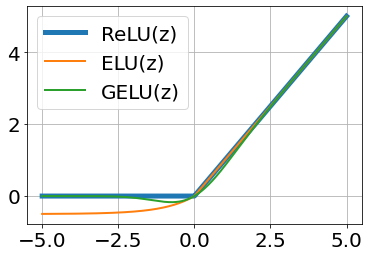

In [17]:
z = torch.linspace(-5, 5, steps=1000)
plt.plot(z.numpy(), torch.relu(z).numpy(), label='ReLU(z)', linewidth=5);
plt.plot(z.numpy(), elu_forward(z, alpha=.5).numpy(), label='ELU(z)', linewidth=2);
plt.plot(z.numpy(), gelu_forward(z).numpy(), label='GELU(z)', linewidth=2);
plt.legend(); plt.grid();

tensor(-0.8279)

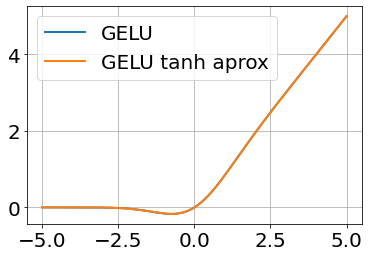

In [38]:
z = torch.linspace(-5, 5, steps=10000)
plt.plot(z.numpy(), gelu_forward(z).numpy(), label='GELU', linewidth=2);
plt.plot(z.numpy(), gelu_forward(z,2).numpy(), label='GELU tanh aprox', linewidth=2);
plt.legend(); plt.grid();
(gelu_forward(z)- gelu_forward(z,2)).abs().sum()

There is one major drawback that we didn't refer to so far, can you guess what it is?

###  Positional Encoding

* Untill now, we saw a strong tool for learning, but if a token came as the first word in the sentence, or as last, we only learned the power of the relation between them, the order did not matter!

* The positional encoding is an idea that reminds Spectral decomposition, like Fourier series, based just on the positions.

* The basis is Sin and Cosin functions with different frequencies as coefficients (2pi, 4pi…)

* The reason of that is that we want to push each embedding a bit to encode the position as well as the meaning, but we also want it to be normalized (why?)

* It is less of an issue for other inputs (images - a bit, pointclouds), but very important in text!

In [8]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model) 
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

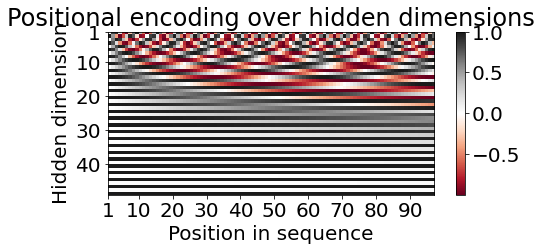

In [9]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

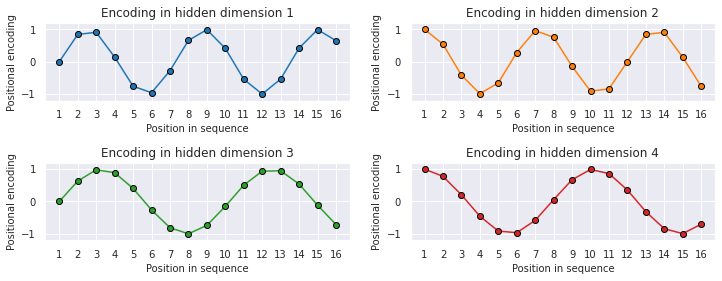

In [10]:
#!pip install seaborn #- if it's not part of the requrement file
import seaborn as sns
import numpy as np
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

## Ways to use it in NLP

* **G**enerative **P**re**T**raining (GPT):  **Encoder only!**. Generate text, stories using nothing but initial tokens.
<br>
<br>
<br>
*  **B**idirectional **E**ncoder **R**epresentations from **T**ransformers (BERT): **Decoder only!** mask prediction over one sequnce, can be use for error fixing, wordtune/gramerly etc.. 
<br>
<br>
<br>
* **T**ext-**T**o-**T**ext **T**ransfer **T**ransformer (T5): Translation, summerization, question answering and so on.


<center><img src="img/bayer.png" width=1400 /></center>


## BRRT

<center><img src="img/bert.png" width=900 /></center>

Uses pre-training of semi (self) supervision of two tasks:

1. masked prediction: mask out 15% of the tokens and predict them using bi-directional encoding of the sentense.

make use of the spacial token `[MASK]` istead of some of the inputs

2. NSP: Next sentence prediction: predict if the next sentence come after the current one or not.

sentences of the same paragraph comes one after the other with a seperation of the special token `[SEP]`

## GPT

<center><img src="img/train.png" width=900 /></center>


What's next? i call it The **moor's law of parameters**:




<center><img src="img/dnns-13.jpg.webp" width=1000 /></center>


Let's try to work with something that is way to big to train here, but we can play with a pre-trained version: GPT2:

<center><img src="img/gpt2.png" width=1000 /></center>


In [39]:
!pip install transformers

In [40]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [45]:
completes = generator("if i had a nickel for every time a student asked me ", max_length=50, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [46]:
for i, sentence in enumerate(completes):
    print(f'===generated sentence number {i}: ===')
    print(' ' + sentence['generated_text']+ '\n\n')

===generated sentence number 0: ===
 if i had a nickel for every time a student asked me  - you have not been able to get a nickel for anything.  It has never been more than 20 cents, so in a nutshell, your money just isn't there.


===generated sentence number 1: ===
 if i had a nickel for every time a student asked me izakaya and i had a nickel for every time a student pointed out that it's not a nickel because they don't have time or money for textbooks, and if I asked them


===generated sentence number 2: ===
 if i had a nickel for every time a student asked me  why I was selling "coupons", and then asked for a 'goodie'.
My first attempt at'sell a goodie' came out the other day when I


===generated sentence number 3: ===
 if i had a nickel for every time a student asked me  to change my credit score.  And yet here I am.  I was so excited to get started in the first semester of the year that I didn't even talk


===generated sentence number 4: ===
 if i had a nickel for every time

We can also explore some of the biases of the LLMs, since they are trained in a self-supervised fashion, the biases are just what can be found online:

In [51]:
generator("This man worked as a", max_length=10, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'This man worked as a barista. What a'},
 {'generated_text': 'This man worked as a lawyer for President Nixon,'},
 {'generated_text': 'This man worked as a manger.\n\n'},
 {'generated_text': 'This man worked as a security guard in a field'},
 {'generated_text': 'This man worked as a bartender at a hotel in'}]

In [50]:
generator("This woman worked as a", max_length=10, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "This woman worked as a maid in the company's"},
 {'generated_text': 'This woman worked as a housekeeper, and was'},
 {'generated_text': 'This woman worked as a delivery girl.'},
 {'generated_text': 'This woman worked as a waitress at a restaurant for'},
 {'generated_text': 'This woman worked as a "nursery supervisor'}]

#### Thanks for your attention (**stagadish**)

**Credits**

This tutorial was written by Moshe Kimhi .<br>
To re-use, please provide attribution and link to the original.

Some images in this tutorial were taken and/or adapted from the following sources:

- Jay Alammar blog - https://jalammar.github.io/illustrated-transformer/
- Attention is all you need paper - https://arxiv.org/abs/1706.03762
- Lucas Beyer - transformer presentation